In [623]:
import numpy as np
import pandas as pd
import os
import random 

import cv2

from datetime import datetime
from matplotlib import pyplot as plt
import string

%matplotlib inline

def randomString(stringLength):
    """Generate a random string with the combination of lowercase and uppercase letters """

    letters = string.ascii_letters
    return ''.join(random.choice(letters) for i in range(stringLength))

def create_annotion(d, full_path):
    s = """<annotation>
<folder>images</folder>
<filename>#FLNM#</filename>
<path>/home/folder/images</path>

<source><database>Unknown</database></source>

<size>
<width>1280</width>
<height>960</height>
<depth>3</depth>
</size>

<segmented>0</segmented>
<object>
<name>#OBJECT_CLASS#</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>#XMIN#</xmin>
<ymin>#YMIN#</ymin>
<xmax>#XMAX#</xmax>
<ymax>#YMAX#</ymax>
</bndbox>
</object>
</annotation>"""
    a = s.split('\n')
    full_path = full_path.replace('.jpg','.xml')
    fl = open( full_path, 'w+')
    print(full_path)
    for i in range(len(a)):
        s=a[i]
        if '#OBJECT_CLASS#' in a[i]: s = a[i].replace('#OBJECT_CLASS#', d['object_class'])
        if '#XMIN#' in a[i]: s = a[i].replace("#XMIN#", str(d['xmin']))
        if '#YMIN#' in a[i]: s = a[i].replace("#YMIN#", str(d['ymin']))
        if '#XMAX#' in a[i]: s = a[i].replace("#XMAX#", str(d['xmax']))
        if '#YMAX#' in a[i]: s = a[i].replace("#YMAX#", str(d['ymax']))
        if '#FLNM#' in a[i]: s = a[i].replace("#FLNM#", d['flnm'])

        #print(s)
        fl.write(s)
    pass

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def get_white_background(Y,X):
    background = np.zeros((Y,X,3), np.uint8)
    background[:,:]=np.array([255,255,255])
    return background

def show_img(w,h,img):
    plt.figure(figsize=(w, h))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def get_passport():
    return cv2.imread('card_shapes_3.jpg')

def get_card1():
    return cv2.imread('card_shapes_1.jpg')

def get_card2():
    return cv2.imread('card_shapes_2.jpg')

def random_angle():
    return random.randint(0, 360)

def new_coords_shapebased(rp):
    randY=random.randint(0, 960-rp.shape[0])
    randX=random.randint(0, 1280-rp.shape[1])
    return randX, randY

def get_col_dict(img):
    unique, counts = np.unique(img, return_counts=True)
    d = dict(zip(unique, counts))
    return d, unique, counts

def clean(background):
    arw = np.array([255, 255, 255])
    for y in range(background.shape[0]):
        subarea = background[y:y+1, 0:background.shape[1]]
        if (subarea==arw).all()==False:
            if y%100==0:
                print('%%', y, (subarea==arw).all(), subarea.shape  )

            size=10
            running_side='beg'
            x = 0
            # X large step loop
            while x < subarea.shape[1]:
                winB = subarea[0:1, x:x+size]
                winS = subarea[0:1, x:x+size-1]
                winP = subarea[0:1, x+size-1:x+size]

                #print(x, (winB==arw).all(), (winS==arw).all())

                if (winB==arw).all()==False and (winS==arw).all()==True:
                    d, unique, counts = get_col_dict(winP)
                    #print(x, d, unique, counts)
                    if len(unique)<3:
                        #print('change color', winP)
                        background[y:y+1, x+size-1:x+size]=white
                        #print(winP)
                        x=x-15
                    #break

                winBR = subarea[0:1, x:x+size]
                winSR = subarea[0:1, x+1:x+size]
                winPR = subarea[0:1, x:x+1]
                if (winBR==arw).all()==False and (winSR==arw).all()==True:
                    #print(winBR)
                    #print(winSR)
                    #print(winPR)
                    d, unique, counts = get_col_dict(winPR)
                    if len(unique)<3:
                        #print('change color', winPR)
                        background[y:y+1, x:x+1]=white
                        #print(winPR)
                        x=x-15
                    #break
                x += 1
    return background

def place_img(background, input_img, angle):
    rp = rotate_bound(input_img, angle)
    randX, randY=new_coords_shapebased(rp)
    #print('rand1', randX, randY)
    #randX, randY = 100,100
    background[randY:randY+rp.shape[0], randX:randX+rp.shape[1]]=rp
    background[np.where((background == black).all(axis = 2))] = white
    return background, {'minx':randX, 'miny':randY, 'maxx':randX+rp.shape[1], 'maxy':randY+rp.shape[0]}

def get_pcg(unique, counts):
    avg=Average(counts)
    last_el=0
    for i in range(1,len(counts)):
        if counts[i]<avg:
            last_el=i
            break

    bigger_part=0
    lesser_part=0
    for i in range(0, len(counts)):
        if i<last_el:bigger_part+=counts[i]
        else: lesser_part+=counts[i]
    pcg=(lesser_part/bigger_part)*100
    return pcg

def place_img_check(back, input_img, angle):

    rp = rotate_bound(input_img, angle)
    rp_mask=np.copy(rp)
    rp_mask[np.where((rp_mask > 0).all(axis = 2))] = white

    #gen new coords considering dimentions
    randX, randY=new_coords_shapebased(rp)
    #show_img(5,5,rp)

    box_new = background[randY:randY+rp.shape[0], randX:randX+rp.shape[1]]
    #show_img(3,3,box_new)

    mask_multiplication = box_new * rp_mask
    #show_img(3,3, mask_multiplication)     

    unique, counts = np.unique(mask_multiplication, return_counts=True)

    response = "none"
    if get_pcg(unique, counts) < .1:
        response = "True"
        print("we're in")
        for i in range(rp.shape[0]):
            for j in range(rp.shape[1]):
                if (background[randY+i:randY+i+1, randX+j:randX+j+1]==np.array([255,255,255])).all():
                    background[randY+i:randY+i+1, randX+j:randX+j+1]=rp[i:i+1,j:j+1]
        background[np.where((background == black).all(axis = 2))] = white
        coords = [randX, randY]
    else:
        response = "False"
        
    return background, response

def gen(background, img, ra):
    resp = "none"    
    ctr = 0
    while resp != "True":
        background, resp = place_img_check(background, img, ra)
        ctr += 1
        if ctr >= 100: break
    return background, resp, ctr

white = np.array([[[255,255,255]]])
black = np.array([[[0,0,0]]])
gray = np.array([[[125,125,125]]])
red = np.array([[[0,0,255]]])


In [ ]:
angle=0
while angle <= 360:
    background = np.array([])
    loop=True
    while loop:
        print('starting')
        background = get_white_background(960, 1280)
        ra1 = random_angle()
        background, coords = place_img(background, get_passport(), ra1)

        ra2 = random_angle()
        background, resp2, ctr2 = gen(background, get_card1(), angle)
        print('@@', resp2, ctr2)    

        ra3 = random_angle()
        background, resp3, ctr3 = gen(background, get_card2(), ra3)
        print('@@', resp3, ctr3)    

        if resp2=='True' and resp3=='True': break

    show_img(10, 10, background)
    background = clean(background)
    
    flnm='generated_'+str(ra1)+'_'+randomString(6)+'.jpg'
    path='/home/greed/documents/generated/'
    fullpath = path+flnm
    print(fullpath)
    cv2.imwrite(fullpath, background)
    d={}
    d['xmin']=coords['minx']
    d['ymin']=coords['miny']
    d['xmax']=coords['maxx']
    d['ymax']=coords['maxy']
    d['flnm']=flnm
    d['object_class']='kg_new_id_back'
    create_annotion(d, fullpath)

    angle += 10
print('done.')

starting
we're in
@@ True 1
we're in
@@ True 2
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)
%% 700 False (1, 1280, 3)
%% 800 False (1, 1280, 3)
%% 900 False (1, 1280, 3)
/home/greed/documents/generated/generated_182_CQDHhE.jpg
/home/greed/documents/generated/generated_182_CQDHhE.xml
starting
we're in
@@ True 8
@@ False 100
starting
we're in
@@ True 3
@@ False 100
starting
we're in
@@ True 30
we're in
@@ True 36
%% 100 False (1, 1280, 3)
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)
%% 700 False (1, 1280, 3)
%% 800 False (1, 1280, 3)
/home/greed/documents/generated/generated_238_pnMosk.jpg
/home/greed/documents/generated/generated_238_pnMosk.xml
starting
we're in
@@ True 4
we're in
@@ True 10
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)


/home/greed/anaconda3/envs/tensorflow_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in long_scalars


we're in
@@ True 60
we're in
@@ True 1
%% 0 False (1, 1280, 3)
%% 100 False (1, 1280, 3)
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)
%% 700 False (1, 1280, 3)
%% 800 False (1, 1280, 3)
%% 900 False (1, 1280, 3)
/home/greed/documents/generated/generated_90_lKFdZP.jpg
/home/greed/documents/generated/generated_90_lKFdZP.xml
starting
we're in
@@ True 3
we're in
@@ True 53
%% 100 False (1, 1280, 3)
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)
%% 700 False (1, 1280, 3)
/home/greed/documents/generated/generated_106_DCwWcH.jpg
/home/greed/documents/generated/generated_106_DCwWcH.xml
starting
we're in
@@ True 3
@@ False 100
starting
we're in
@@ True 1
@@ False 100
starting
we're in
@@ True 3
@@ False 100
starting
we're in
@@ True 2
we're in
@@ True 3
%% 100 False (1, 1280, 3)
%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)

%% 200 False (1, 1280, 3)
%% 300 False (1, 1280, 3)
%% 400 False (1, 1280, 3)
%% 500 False (1, 1280, 3)
%% 600 False (1, 1280, 3)
%% 700 False (1, 1280, 3)
%% 800 False (1, 1280, 3)
%% 900 False (1, 1280, 3)


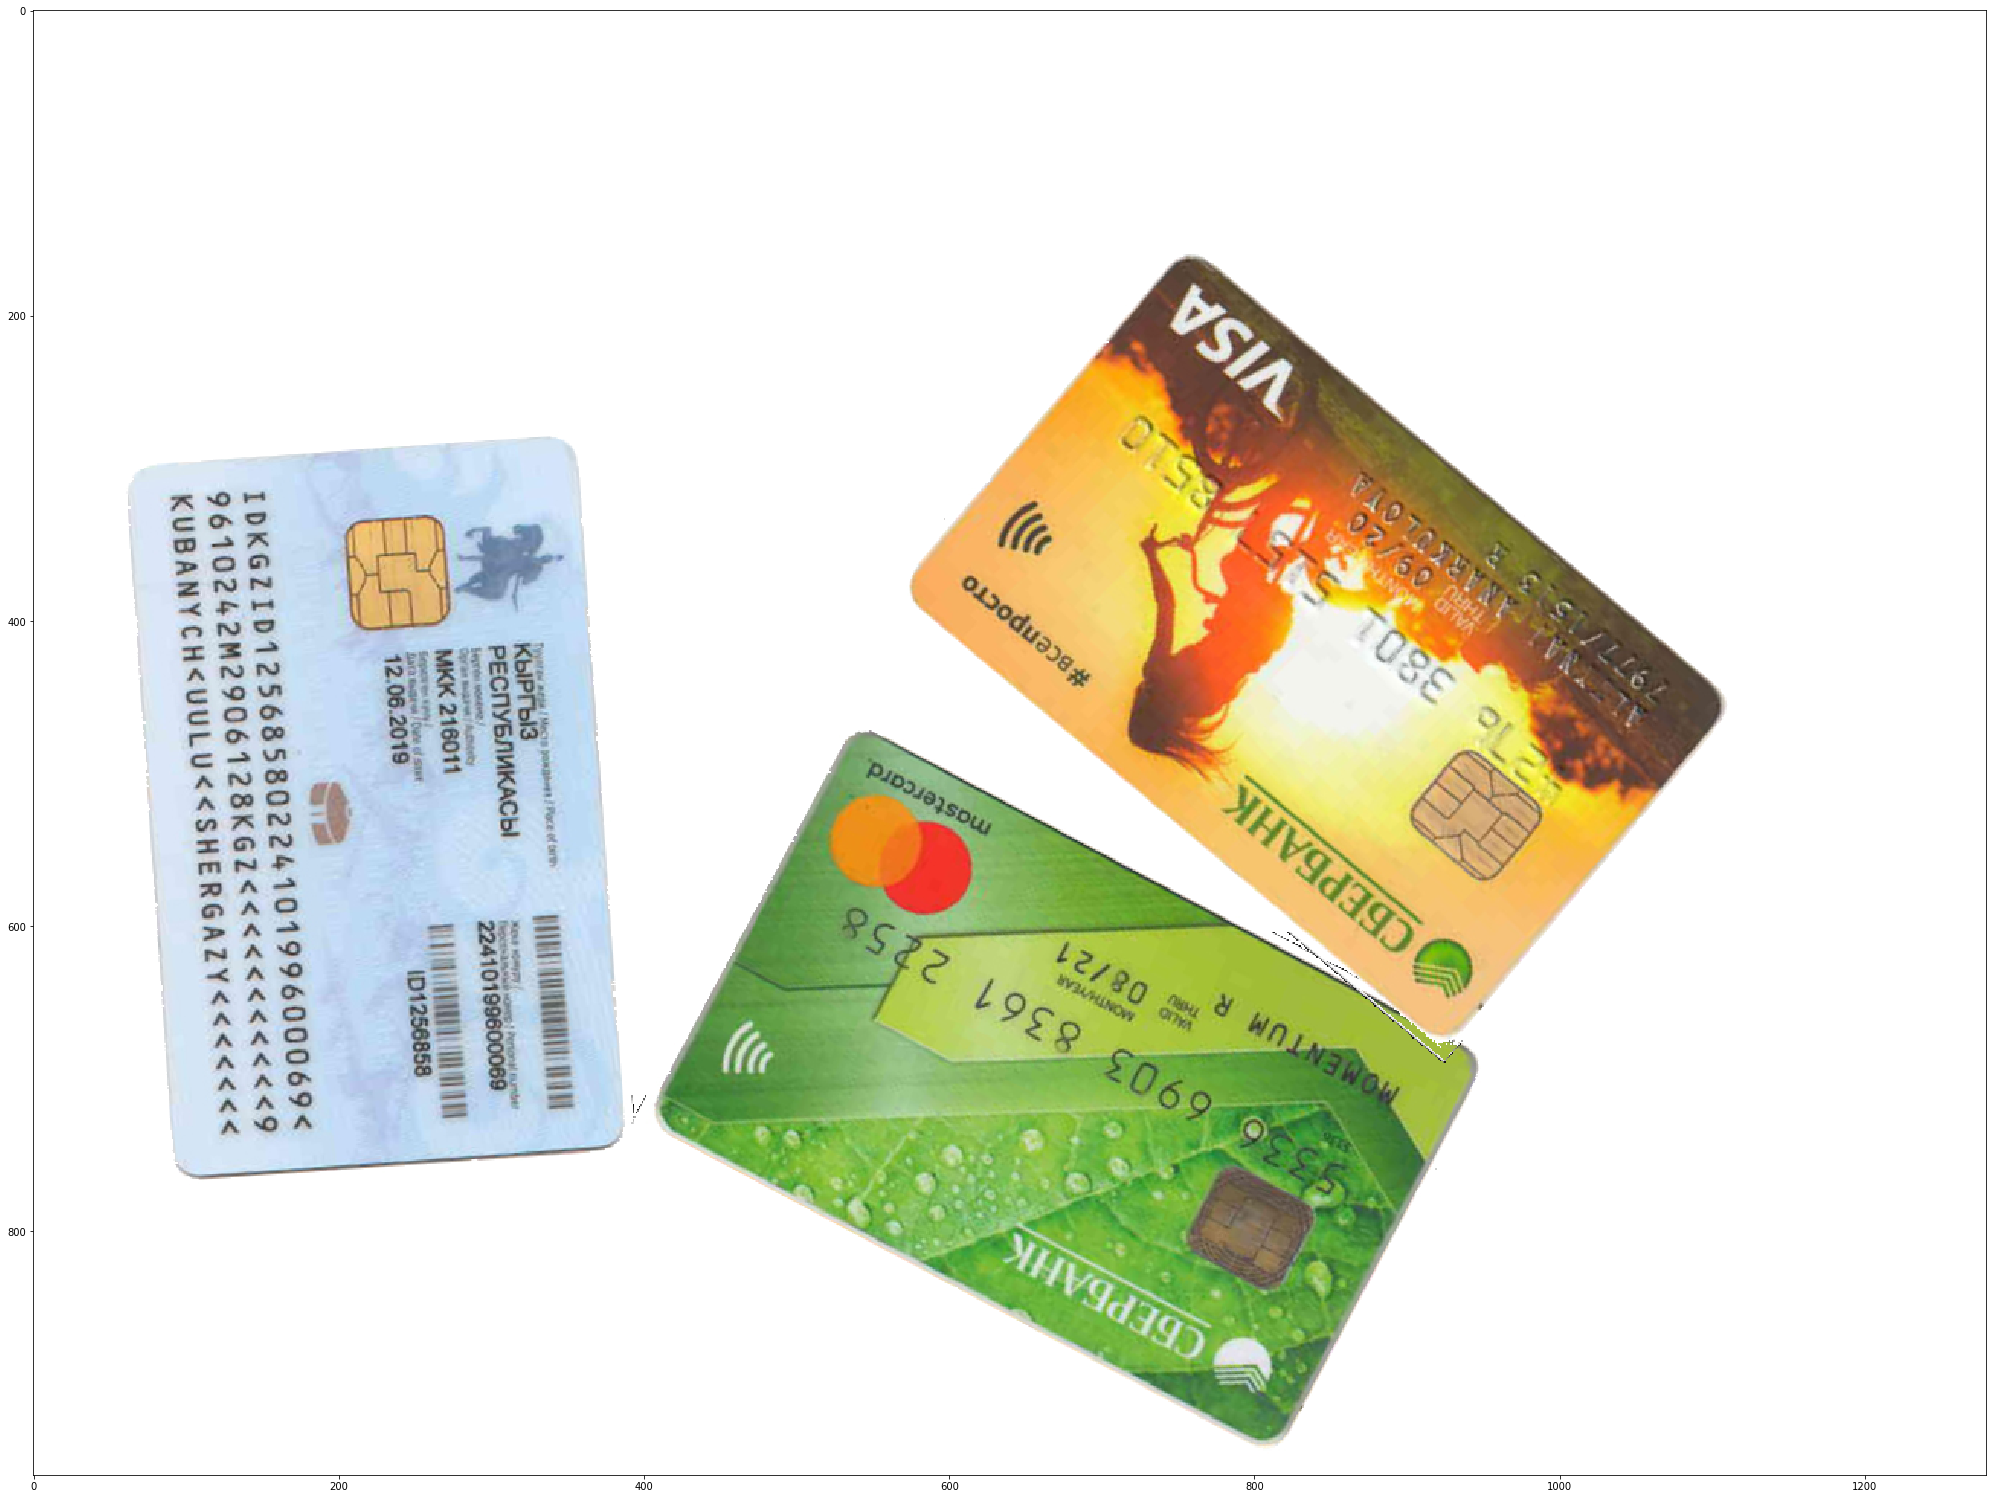

In [581]:
show_img(35, 35, clean(background))


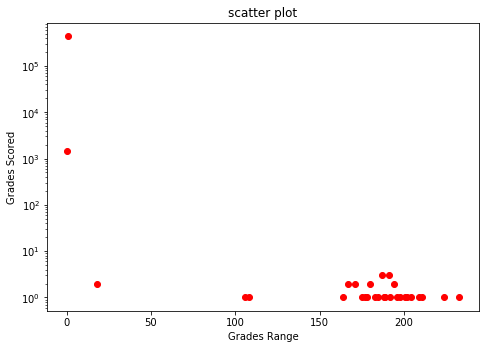

0.008065166545689168


In [508]:
#print(unique, counts)
def Average(lst): 
    return sum(lst) / len(lst) 

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(unique, counts, color='r')
ax.set_xlabel('Grades Range')
ax.set_ylabel('Grades Scored')
ax.set_title('scatter plot')
ax.set_yscale('log')
plt.show()


print(get_pcg(unique, counts))

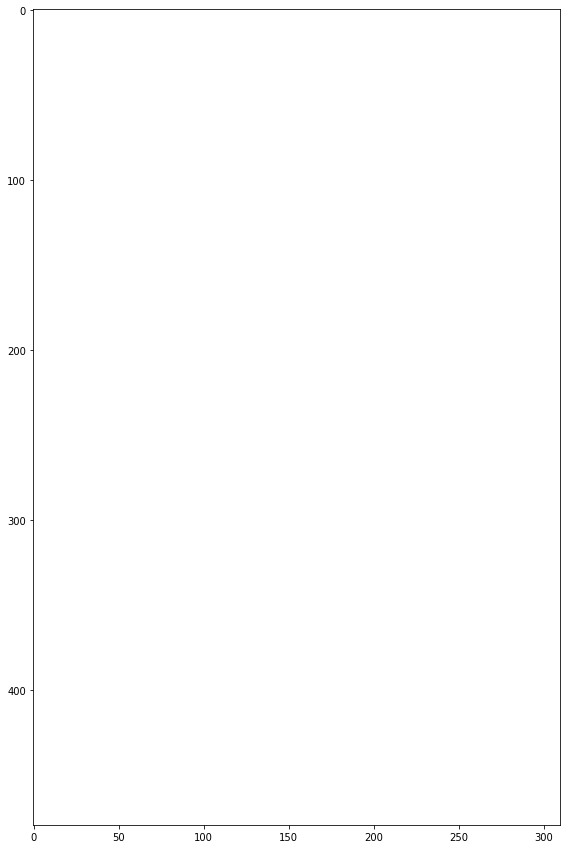

In [437]:
#tmp = np.copy(box_new)
tmp[np.where((tmp < 255).all(axis = 2))] = black


show_img(15, 15, tmp)